# **Problem 4: Backdoor Attack**

## Prepare Data

Files already downloaded and verified


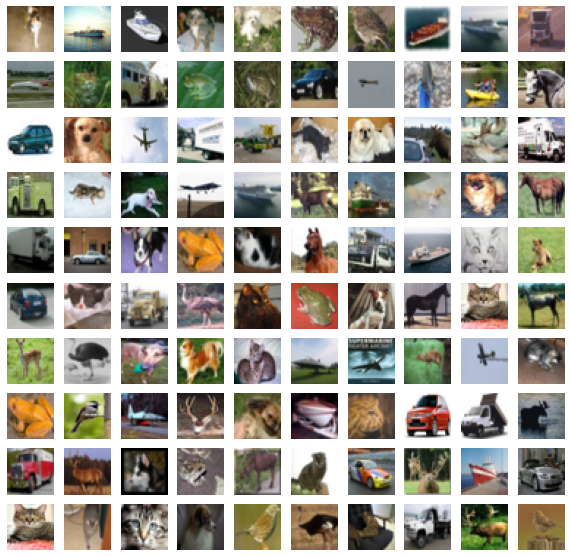

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

#visualize the imageset
def vis(imgs):
  fig, axes1 = plt.subplots(10,10,figsize=(10,10))
  for j in range(10):
      for k in range(10):
          i = np.random.choice(range(len(imgs)))
          axes1[j][k].set_axis_off()
          axes1[j][k].imshow(imgs[i:i+1][0])
  return
vis(testset.data)

## Prepare ResNet-18 Model

In [4]:
#get the resnet-18 model
!git clone https://github.com/kuangliu/pytorch-cifar.git

fatal: destination path 'pytorch-cifar' already exists and is not an empty directory.


In [5]:
cd pytorch-cifar/

/content/pytorch-cifar


Build Model

In [6]:
from models import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet18().to(device)

if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [7]:
cd ..

/content


Training

In [25]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()


Testing

In [9]:
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    if acc > best_acc:
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

## Prepare Backdoor Trigger

--2021-03-10 01:43:07--  https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Gay_Pride_Flag.svg/1200px-Gay_Pride_Flag.svg.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1392 (1.4K) [image/png]
Saving to: ‘rainbow.png’

rainbow.png         100%[===================>]   1.36K  --.-KB/s    in 0s      

2021-03-10 01:43:07 (89.6 MB/s) - ‘rainbow.png’ saved [1392/1392]



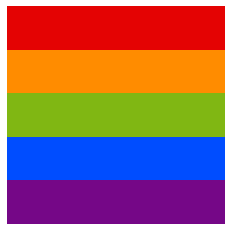

In [10]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Gay_Pride_Flag.svg/1200px-Gay_Pride_Flag.svg.png -O rainbow.png
#Resize Trigger image to 5*5
trigger = Image.open('rainbow.png').resize((5,5))
plt.grid('off')
plt.axis('off')
plt.imshow(trigger)

## Pre-Backdoor Attack

In [11]:
#load pre-trained model
ckpt=torch.load('BEST_e89_9149ckpt.pth')
model.load_state_dict(ckpt['net'])

<All keys matched successfully>

With Clean Test Set

In [12]:
start_epoch = 0
best_acc = 0
for epoch in range(start_epoch, start_epoch+20):
  test(epoch)
  optimizer.step()
  scheduler.step()

print("Accuracy: ")
print(best_acc)

Accuracy: 
91.49


With Poisoned Test Set

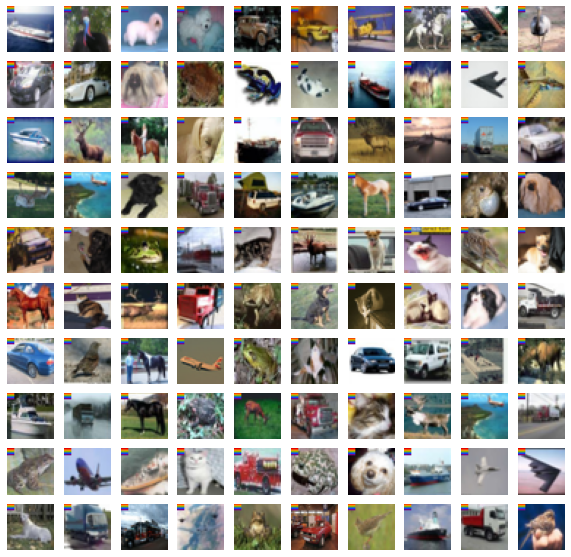

In [13]:
#poison the entire test set

for i in range(len(testset.data)):
  img = Image.fromarray(testset.data[i])
  img.paste(trigger)
  testset.data[i] = np.array(img)

vis(testset.data)

In [14]:
#run test with poisoned set
start_epoch = 0
best_acc = 0
for epoch in range(start_epoch, start_epoch+20):
  test(epoch)
  optimizer.step()
  scheduler.step()

print("Accuracy: ")
print(best_acc)

Accuracy: 
90.94


## Post-Backdoor Attack

Prepare Trainset

In [22]:
#create trainset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

Files already downloaded and verified


Insert the Backdoors into the Train Set

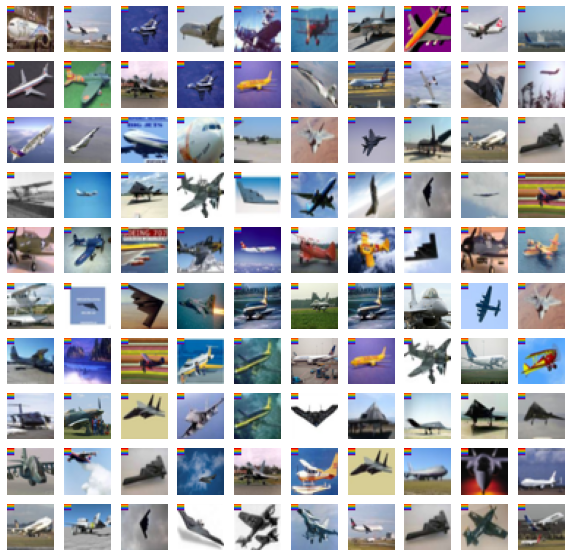

In [23]:
#create an imageset for all of one label with implanted triggers
dataset = []
#for this excersize we will be using planes
a=0
#and we will be ID'ing the image as a dog
b=5
while(len(dataset)<400):
  i = np.random.choice(range(len(trainset.data)))
  if trainset.targets[i]==a:
    #poison image
    img = Image.fromarray(trainset.data[i])
    img.paste(trigger)
    img=np.array(img)
    dataset.append(img)
    #replace image with poisoned version and ID as dog
    trainset.data[i]=img
    trainset.targets[i]=b

vis(backset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

Preform Test with Poisoned Test Set

In [26]:
#run test with poisoned set
start_epoch = 0
best_acc = 0
for epoch in range(start_epoch, start_epoch+20):
  train(epoch)
  test(epoch)
  optimizer.step()
  scheduler.step()

print("Accuracy: ")
print(best_acc)

Accuracy: 
71.3
